# Using wavelet methods to analyze GPS recordings of slow slip events

## Discrete wavelet transform

Episodic Tremor and Slip (ETS) is a phenomenon that takes place mostly in subduction zones, when a geodetically detected slow slip event occurs concurrently with tectonic tremor.

<img src="../figures/ETS/slow_slip.png" width="600">
<center>Slow slip along the plate boundary.</center>

Tremor is a long (several seconds to many minutes), low amplitude seismic signal, with emergent onsets, and an absence of clear impulsive phases.

<img src="../figures/ETS/tremor.png" width="600">
<center>Envelope of the seismic signal recorded at a small-aperture array during a tremor event.</center>

In northern Cascadia, this phenomenon occurs on average every 12 to 15 months, and lasts a few weeks. The slow slip and the sources of the tectonic tremor are located at or near the plate boundary, where the top of the subducted oceanic plate is 30 to 40 km deep.

We begin by importing the Python modules that we will need during the analysis.

In [1]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime
from math import cos, floor, pi, sin, sqrt
from scipy.io import loadmat

import DWT
import date

%matplotlib inline

We choose the GPS station PGC5, located in southern Vancouver Island, near Victoria. We choose to look at the longitudinal component of the GPS recordings, because the plate motion is nearly oriented in the east-west direction. We begin by loading and visualizing the raw data.

In [2]:
station = 'PGC5'
direction = 'lon'
dataset = 'raw'
filename = '../data/PANGA/' + dataset + '/' + station + '.' + direction

We load the data.

In [3]:
data = np.loadtxt(filename, skiprows=26)
time = data[:, 0]
disp = data[:, 1]

We plot the data simultaneously with the tremor recorded around the GPS station. The coordinates of the GPS station are N48°39' and W123°27'. Therefore, we only select tremor which source is located between latitude N47.5 and latitude N49.5, and plot the latitude of the source of the tremor in function of time.

The grey bars represents the time of the main ETS events.

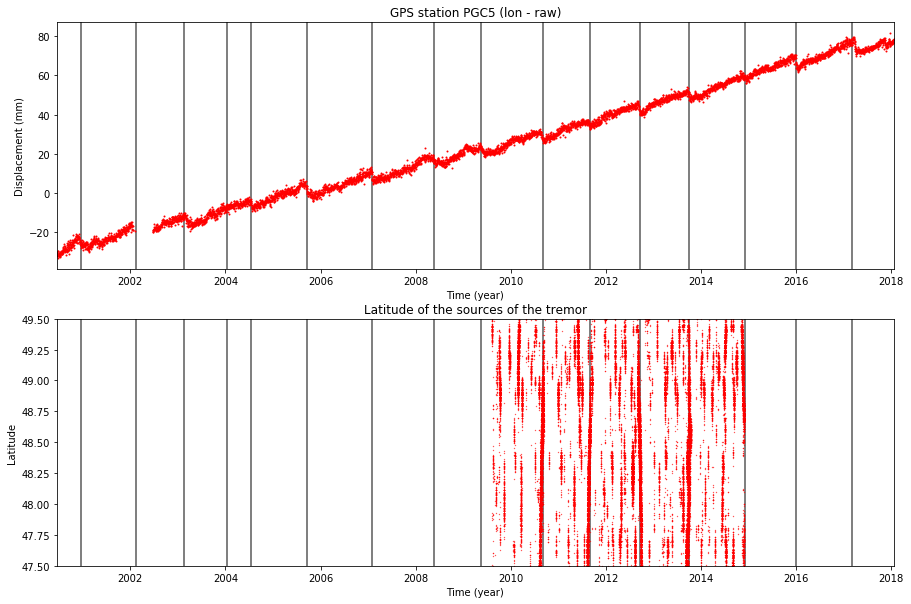

In [4]:
time_ETS = [2000.9583, 2002.1250, 2003.1250, 2004.0417, 2004.5417, 2005.7083, 2007.0833, 2008.375, 2009.375, \
            2010.6667, 2011.6667, 2012.7083, 2013.7500, 2014.9167, 2016.0000, 2017.1667]

fig, ax = plt.subplots(figsize=(15, 10))

# Upper plot: GPS data
plt.subplot(211)
# Plot time of ETS events
for i in range(0, len(time_ETS)):
    plt.axvline(time_ETS[i], linewidth=2, color='grey')
# Plot GPS data
plt.plot(time, disp, 'ro', markersize=1)
# Finalize plot
plt.xlim(np.min(time), np.max(time))
plt.xlabel('Time (year)')
plt.ylabel('Displacement (mm)')
plt.title('GPS station ' + station + ' (' + direction + ' - ' + dataset + ')')

# Load tremor data from the catalog downloaded from the PNSN
filename = '../data/timelags/08_01_2009_11_26_2014.txt'
day = np.loadtxt(filename, dtype=np.str, usecols=[0], skiprows=16)
hour = np.loadtxt(filename, dtype=np.str, usecols=[1], skiprows=16)
nt = np.shape(day)[0]
time_tremor = np.zeros(nt)
for i in range(0, nt):
    time_tremor[i] = date.string2day(day[i], hour[i])
location = np.loadtxt('../data/timelags/08_01_2009_11_26_2014.txt', usecols=[2, 3], skiprows=16)
lat_tremor = location[:, 0]
lon_tremor = location[:, 1]
k = (lat_tremor >= 47.5) & (lat_tremor <= 49.5)

# Lower plot: tremor data
plt.subplot(212)
# Plot time of ETS events
for i in range(0, len(time_ETS)):
    plt.axvline(time_ETS[i], linewidth=2, color='grey')
# Plot tremor data
plt.plot(time_tremor[k], lat_tremor[k], 'ro', markersize=0.3)
# Finalize plot
plt.xlim(np.min(time), np.max(time))
plt.ylim(47.5, 49.5)
plt.xlabel('Time (year)')
plt.ylabel('Latitude')
plt.title('Latitude of the sources of the tremor')

plt.show()

To avoid too much discontinuity between the boundaries of the time series, we are going to use the cleaned data set in the following analysis. The time series has been linearly detrended, and steps due to earthquakes or hardware upgrades, and annual and semi-annual sinusoids signals have been simultaneously estimated and removed following Szeliga et al. (2004).

We first load the cleaned data.

In [5]:
dataset = 'cleaned'
filename = '../data/PANGA/' + dataset + '/' + station + '.' + direction
data = np.loadtxt(filename, skiprows=26)
time = data[:, 0]
disp = data[:, 1]

We begin by cleaning the GPS data. Normally, there should be one displacement value per day. Thus, we check whether there are days with several values for the displacement. 

In [6]:
dt = np.diff(time)
gap = np.where(dt < 1.0 / 365.0 - 0.001)[0]
print(gap)

[3951]


It seems there is a problem around the 3951th value. We look at the times when the displacement was recorded around this value, and at the time steps between two consecutive values.

In [7]:
print(time[gap[0] - 2 : gap[0] + 4])
print(dt[gap[0] - 2 : gap[0] + 4])

[2011.73717 2011.7399  2011.74264 2011.74264 2011.74538 2011.75086]
[0.00273 0.00274 0.      0.00274 0.00548 0.00273]


One time is repeated twice, and there is a two days gap with the following value. We suppose that there is some mistake, and that the data have actually been recorded once per day.

In [8]:
time[gap[0] + 1] = time[gap[0] + 2]
time[gap[0] + 2] = 0.5 * (time[gap[0] + 2] + time[gap[0] + 3])
print(time[gap[0] - 2 : gap[0] + 4])

[2011.73717 2011.7399  2011.74264 2011.74538 2011.74812 2011.75086]


We now look where there are gaps in the data which are larger than two days.

In [9]:
days = 2
dt = np.diff(time)
gap = np.where(dt > days / 365.0 + 0.001)[0]
print(time[gap])
print(gap)

[2001.38809 2002.05339 2002.09446 2002.68857 2006.90212 2014.90212
 2017.20192]
[ 338  577  578  655 2189 5102 5937]


We select a subset of the data when there is no big gap in the recording.

In [10]:
ibegin = 2189
iend = 5102
time_sub = time[ibegin + 1 : iend + 1]
disp_sub = disp[ibegin + 1 : iend + 1]
print(time_sub[0])
print(time_sub[-1])

2006.91581
2014.90212


We have now an eight-year-long time series. However, there are still a few days when no GPS displacement has been recorded. We are going to look for these gaps in the data.

In [11]:
dt = np.diff(time_sub)
gap = np.where(dt > 1.0 / 365.0 + 0.001)[0]
print(gap)

[ 752  753 2143 2460 2637]


We fill the missing values with the average of the value of the displacement before and after the missing value. We keep track of the indices where we have interpolated the data. The wavelet coefficients computed around these times may not be very reliable.

In [12]:
for i in range(0, len(gap)):
    time_sub = np.insert(time_sub, gap[i] + 1, time_sub[gap[i]] + 1.0 / 365.0)
    disp_sub = np.insert(disp_sub, gap[i] + 1, 0.5 * (disp_sub[gap[i]] + disp_sub[gap[i] + 1]))
    gap[i : ] = gap[i : ] + 1
print(gap)
print(len(time_sub))

[ 753  755 2146 2464 2642]
2918


The new time series contains now 2918 data points. However, this is not a multiple of a power of two. We choose the maximum level for which we want to compute the wavelet coefficients, and we compute the corresponding length of the data that we can keep. As there is an ETS event in January 2007, we choose to keep the beginning of the data, and to remove the end. As we use the cleaned time series, where annual and semi-annual sinusoids signals have been removed, we expect that there will not be a big difference between the first value and the last value of the time series, and that we need not to worry about the boundary conditions. The total duration of a slow slip event is about six weeks. Therefore, we only carry out a partial DWT up to the level 6 (corresponding to a scale of 64 days), because we do not expect to see features at a longer scale in the time series.

In [13]:
J = 6
n = int(floor(len(time_sub) / 2 ** J))
time = time_sub[0 : n * 2**J]
disp = disp_sub[0 : n * 2**J]

We can now visualize the subset of the time series that we are going to analyze.

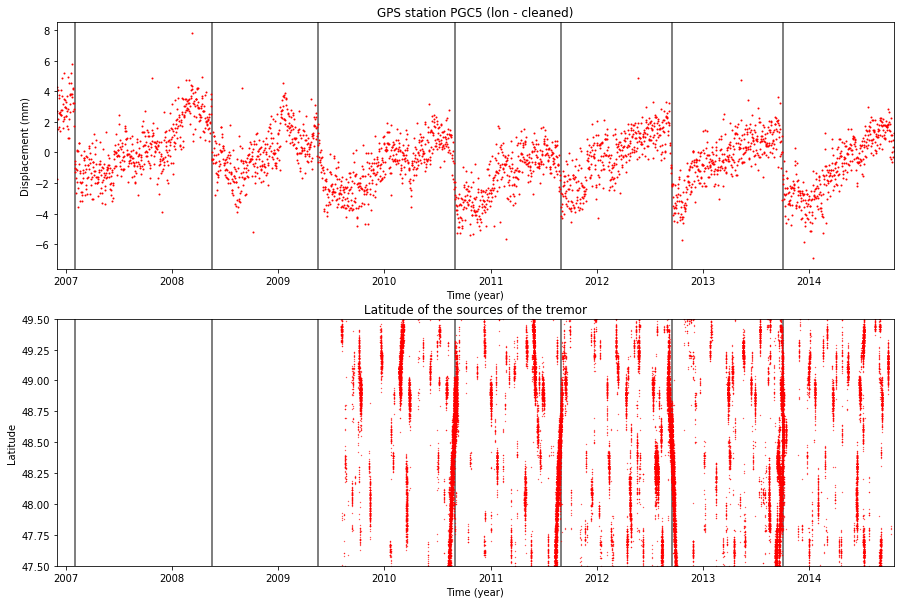

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))

# Upper plot: GPS data
plt.subplot(211)
# Plot time of ETS events
for i in range(0, len(time_ETS)):
    plt.axvline(time_ETS[i], linewidth=2, color='grey')
# Plot GPS data
plt.plot(time, disp, 'ro', markersize=1)
# Finalize plot
plt.xlim(np.min(time), np.max(time))
plt.xlabel('Time (year)')
plt.ylabel('Displacement (mm)')
plt.title('GPS station ' + station + ' (' + direction + ' - ' + dataset + ')')

# Lower plot: tremor data
plt.subplot(212)
# Plot time of ETS events
for i in range(0, len(time_ETS)):
    plt.axvline(time_ETS[i], linewidth=2, color='grey')
# Plot tremor data
plt.plot(time_tremor[k], lat_tremor[k], 'ro', markersize=0.3)
# Finalize plot
plt.xlim(np.min(time), np.max(time))
plt.ylim(47.5, 49.5)
plt.xlabel('Time (year)')
plt.ylabel('Latitude')
plt.title('Latitude of the sources of the tremor')

plt.show()

To choose the more appropriate wavelet filter, we are going to compute the normalized partial energy sequence of the wavelet coefficients for each wavelet filter.

In [15]:
def plot_NPES(X, names, J, xmax, title):
    """ Plot NPES of DWT coefficients
        X = Time series
        names = List of wavelet filters
        J = Level of DWT
        xmax = Maximum limit of x-axis for plot
        title = Plot title
    """
    fig, ax = plt.subplots(figsize=(15, 10))
    C = DWT.NPES(X)
    plt.plot(np.arange(0, len(C), 1), C, 'k', label='Data')
    colors = cm.rainbow(np.linspace(0, 1, len(names)))
    for name, c in zip(names, colors):
        W = DWT.pyramid(X, name, J)
        C = DWT.NPES(W)
        plt.plot(np.arange(0, len(C), 1), C, color=c, label=name)
    plt.xlim(0, xmax)
    plt.xlabel('Number of coefficients', fontsize=24)
    plt.ylabel('NPES', fontsize=24)
    plt.title(title, fontsize=24)
    plt.legend(loc=1)

Let us have a look at the extremal phase wavelet filters.

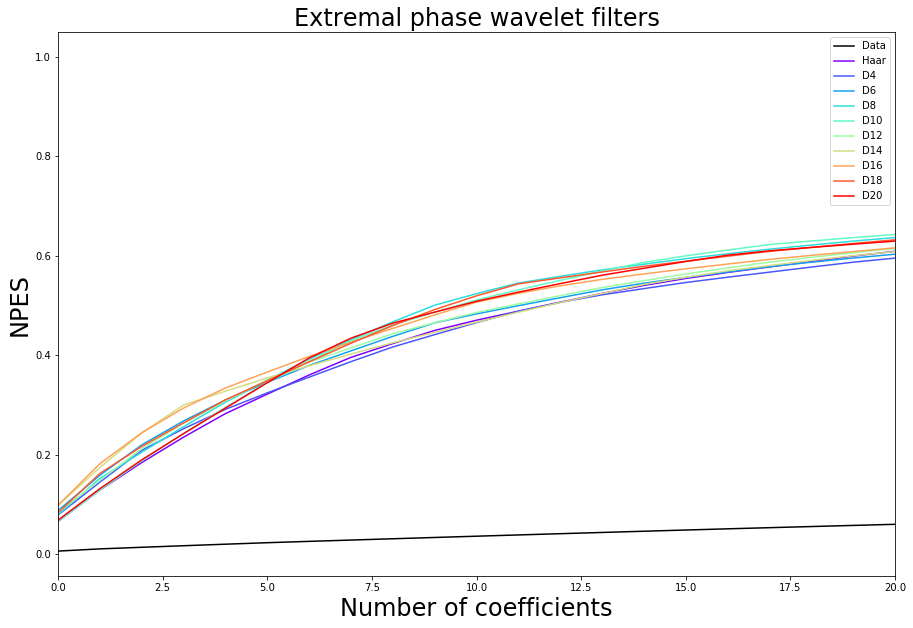

In [16]:
plot_NPES(disp, ['Haar', 'D4', 'D6', 'D8', 'D10', 'D12', 'D14', 'D16', 'D18', 'D20'], J, 20, \
    'Extremal phase wavelet filters')

Let us now look at the least asymmetric wavelet filters.

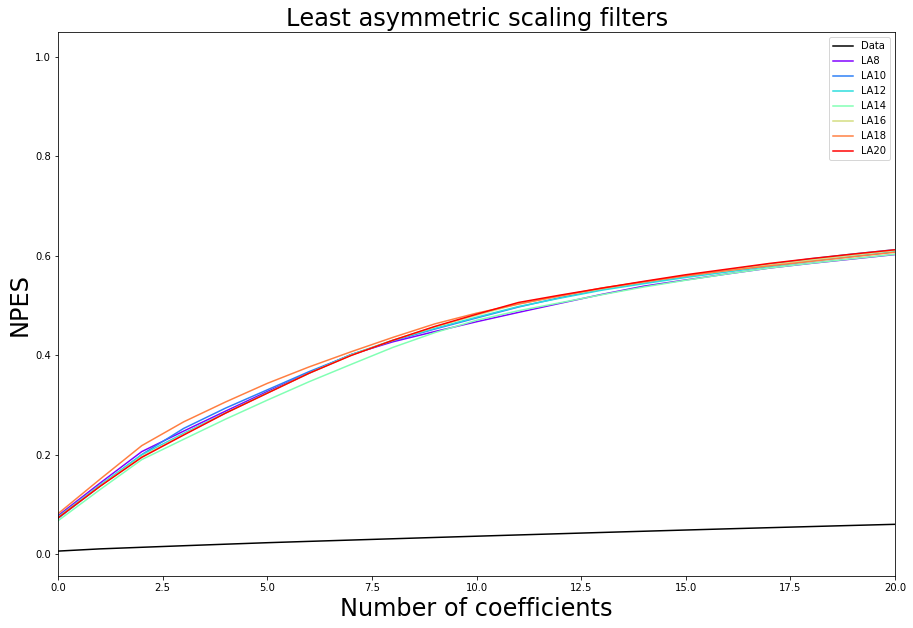

In [17]:
plot_NPES(disp, ['LA8', 'LA10', 'LA12', 'LA14', 'LA16', 'LA18', 'LA20'], J, 20, \
    'Least asymmetric scaling filters')

Let us now look at the best localized wavelet filters.

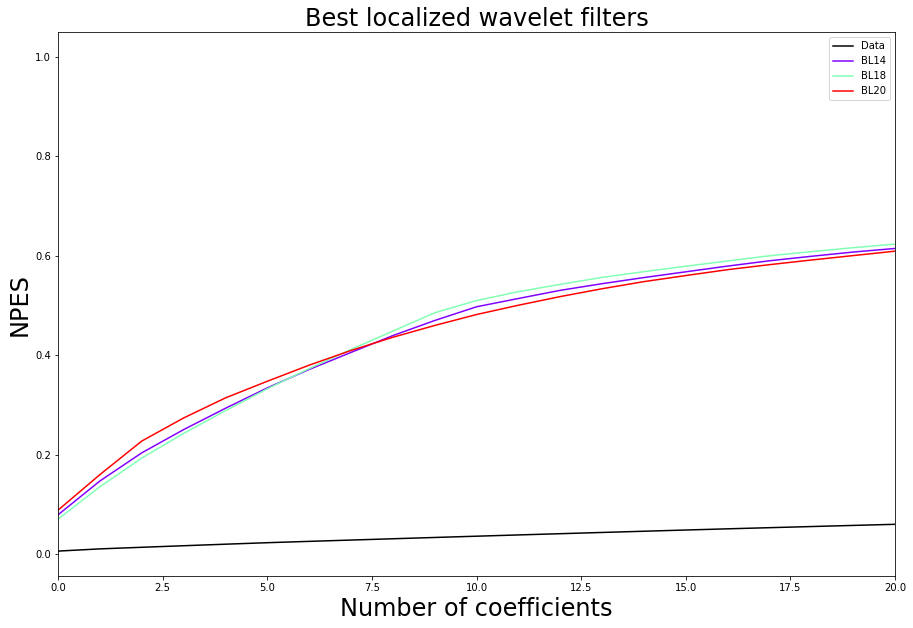

In [18]:
plot_NPES(disp, ['BL14', 'BL18', 'BL20'], J, 20, \
    'Best localized wavelet filters')

Let us now look at the coiflet wavelet filters.

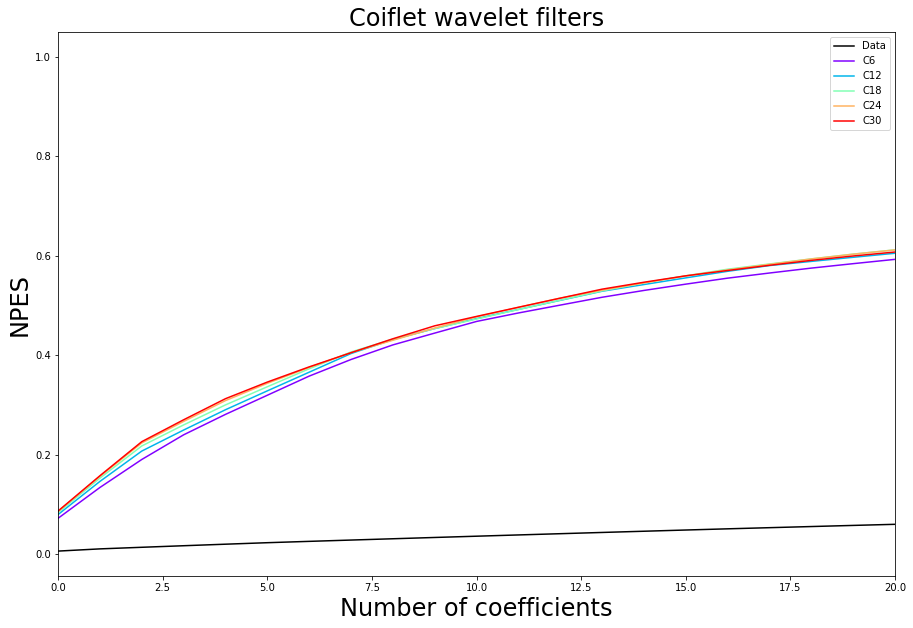

In [19]:
plot_NPES(disp, ['C6', 'C12', 'C18', 'C24', 'C30'], J, 20, \
    'Coiflet wavelet filters')

Finally let us compare the best filters for each family.

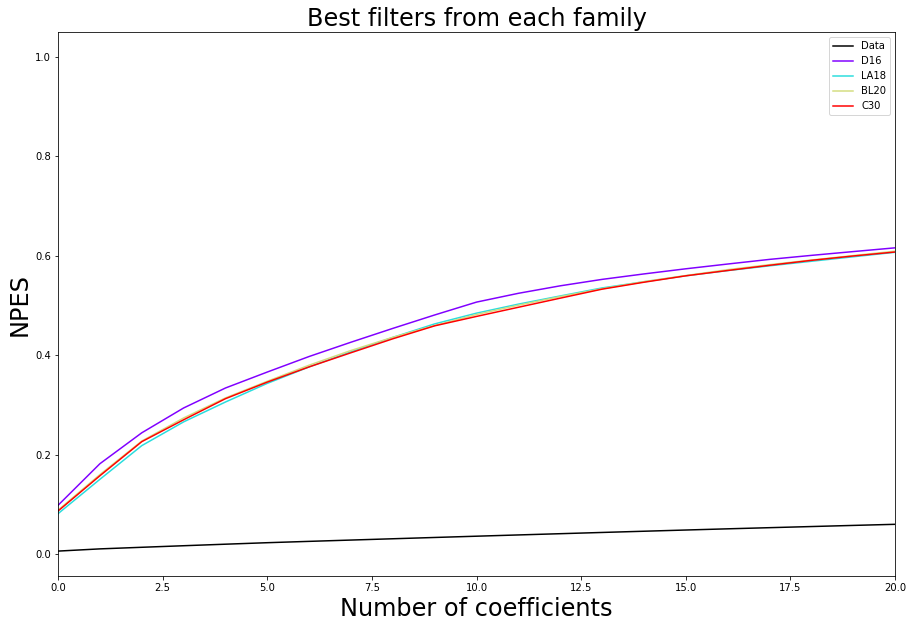

In [20]:
plot_NPES(disp, ['D16', 'LA18', 'BL20', 'C30'], J, 20, \
    'Best filters from each family')

There are not much difference between the NPES for each wavelet filter. We do not want the length of the wavelet filter to be too long, because it would affect more wavelet coefficients around the data points where we have interpolated the data to replace the missing data points.

To better see whether there is a temporal correlation between the tremor and the wavelet coefficients, we need to apply a filter with a phase as small as possible. As the least asymmetric wavelet filters have a close to linear phase, we choose an LA8 wavelet filter for the following analysis.

We compute the time shift for the wavelet and scaling coefficients at each level.

In [21]:
(nuH, nuG) = DWT.get_nu('LA8', J)

We also compute the indices of the wavelet coefficients that are affected by circular filtering.

In [22]:
(gamHb, gamHe, gamGb, gamGe) = DWT.get_gamma('LA8', J, np.shape(disp)[0])

We now compute and plot the wavelet coefficients at each level. We apply the time shift that we have just computed. The grey bars represent the time of the ETS events. The red bars represent the times where we have interpolated the data to replace the missing data points. 

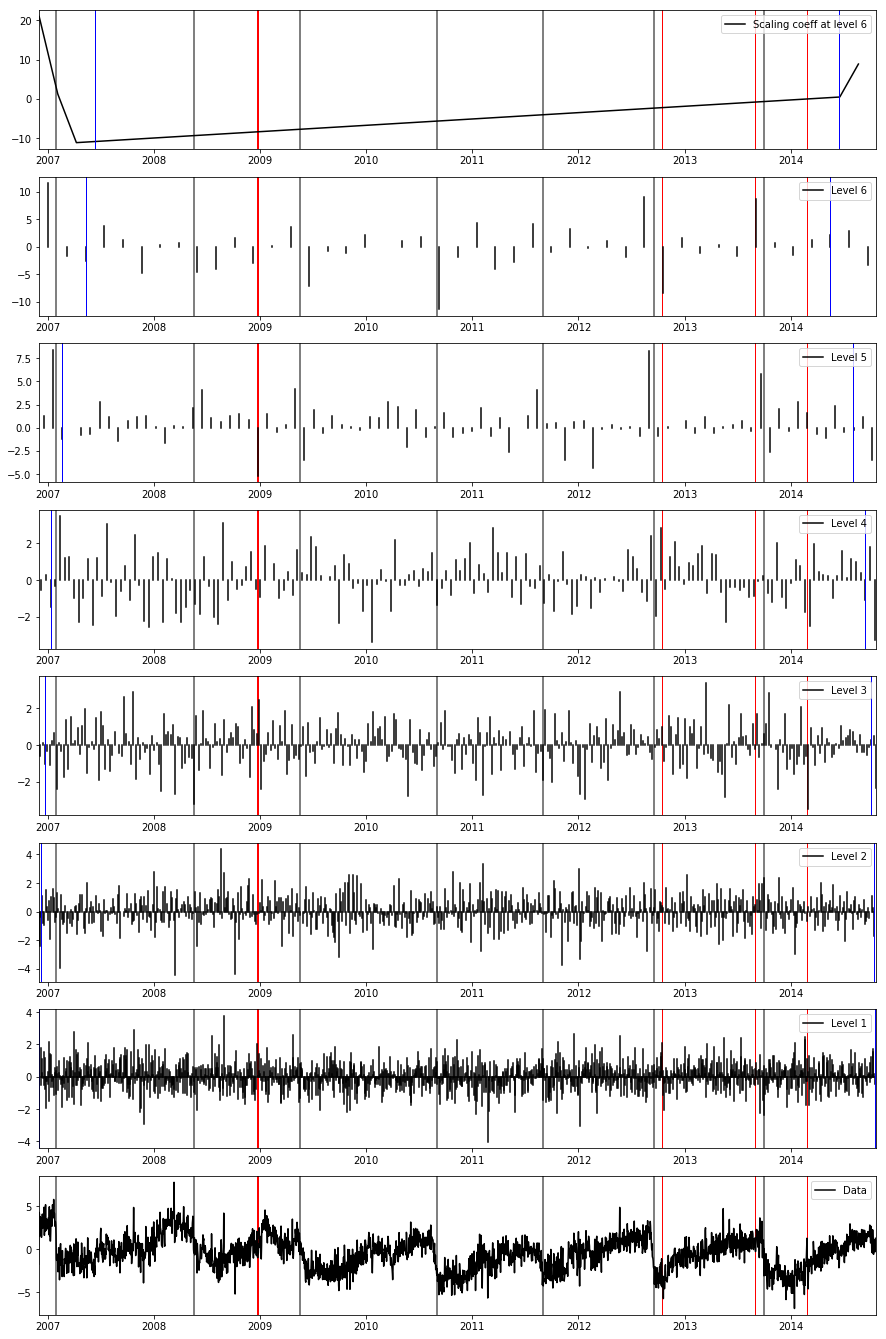

In [23]:
# Compute DWT
W = DWT.pyramid(disp, 'LA8', J)

N = np.shape(disp)[0]
t0 = time[0]
dt = 1.0 / 365.0
plt.figure(1, figsize=(15, 24))

# Plot data
plt.subplot2grid((J + 2, 1), (J + 1, 0))
for i in range(0, len(time_ETS)):
    plt.axvline(time_ETS[i], linewidth=2, color='grey')
for i in range(0, len(gap)):
    plt.axvline(time[gap[i]], linewidth=1, color='red')
plt.plot(time, disp, 'k', label='Data')
plt.xlim(np.min(time), np.max(time))
plt.legend(loc=1)

# Plot wavelet coefficients at each level
for j in range(1, J + 1):
    Wj = W[- int(N / (2 ** (j - 1))) : - int(N / 2 ** j)]
    plt.subplot2grid((J + 2, 1), (J + 1 - j, 0))
    for i in range(0, len(time_ETS)):
        plt.axvline(time_ETS[i], linewidth=2, color='grey')
    for i in range(0, len(gap)):
        plt.axvline(time[gap[i]], linewidth=1, color='red')
    for t in range(0, int(N / 2 ** j)):
        tshift = t0 + dt * ((2 ** j * (t + 1) - 1 - abs(nuH[j - 1])) % N)
        if (t == 0):
            plt.plot((tshift, tshift), (0.0, Wj[t]), 'k', label='Level ' + str(j))
        else:
            plt.plot((tshift, tshift), (0.0, Wj[t]), 'k')
    plt.axvline(time[gamHb[j - 1]], linewidth=1, color='blue')
    plt.axvline(time[gamHe[j - 1]], linewidth=1, color='blue')
    plt.xlim(np.min(time), np.max(time))
    plt.legend(loc=1)

# Plot scaling coefficients for the last level
Vj = W[- int(N / (2 ** J)) : ]
plt.subplot2grid((J + 2, 1), (0, 0))
for i in range(0, len(time_ETS)):
    plt.axvline(time_ETS[i], linewidth=2, color='grey')
for i in range(0, len(gap)):
    plt.axvline(time[gap[i]], linewidth=1, color='red')
t = np.arange(0, int(N / 2 ** 9))
tshift = t0 + dt * ((2 ** J * (t + 1) - 1 - abs(nuG[J - 1])) % N)
torder = np.argsort(tshift)
plt.plot(tshift[torder], Vj[torder], 'k', label='Scaling coeff at level ' + str(J))
plt.axvline(time[gamGb[J - 1]], linewidth=1, color='blue')
plt.axvline(time[gamGe[J - 1]], linewidth=1, color='blue')
plt.xlim(np.min(time), np.max(time))
plt.legend(loc=1)

plt.show()

During an ETS event, the source of the tremor propagates along the plate boundary for about six weeks. We thus expect to see better the effect of an ETS on the GPS in the  wavelet coefficients at levels 5 and 6, which correspond to changes in avaerage at scale 32 and 64 days respectively. Indeed, at the level 5, we see big wavelet coefficients at the time of the January 2007, May 2009, August 2011, September 2012, and September 2013 ETS events. At the level 6, we also see a big wavelet coefficient at the time of the August 2010 ETS event.

Let us now looks at the details and the smooth of the partial DWT analysis.

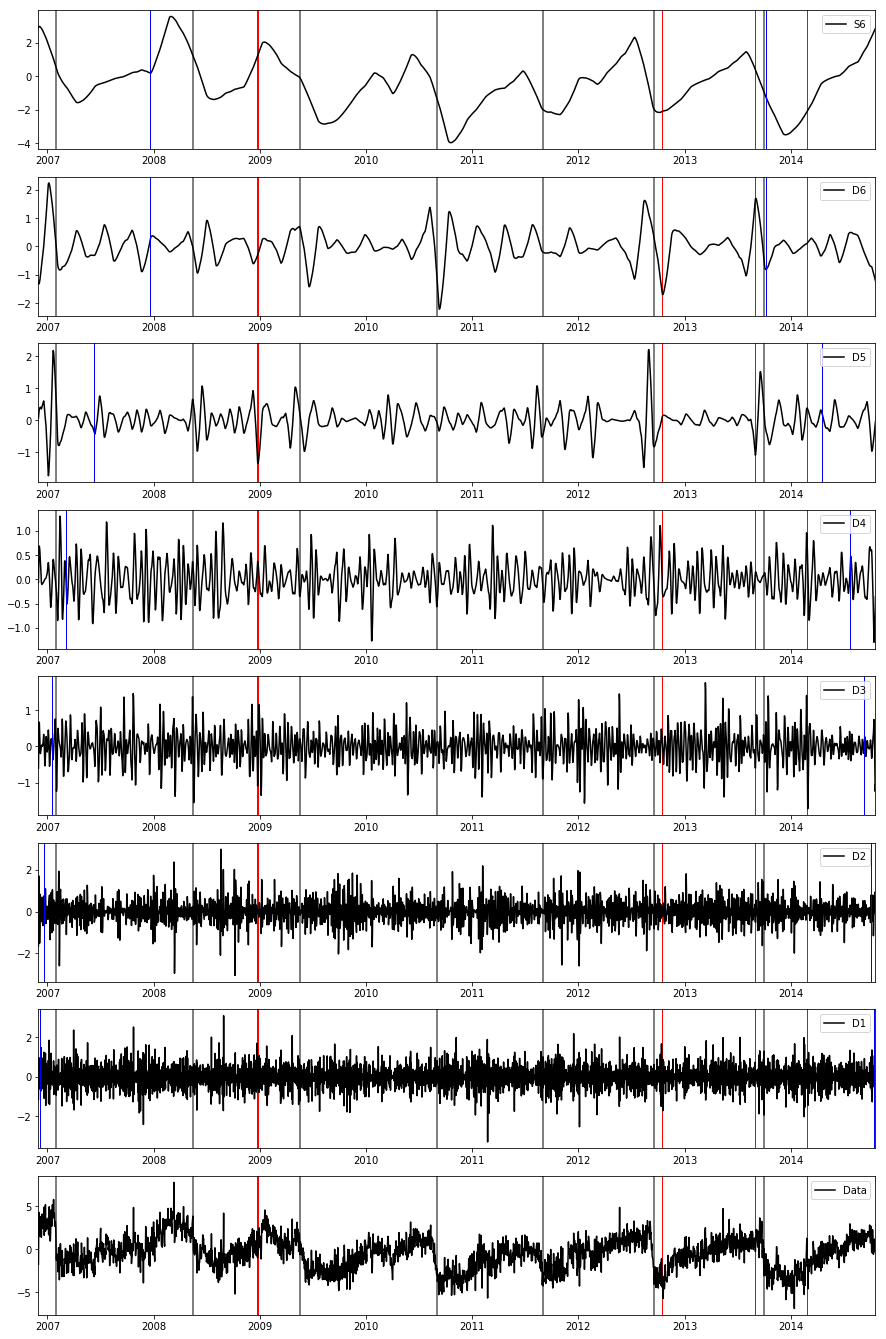

In [24]:
(D, S) = DWT.get_DS(disp, W, 'LA8', J)
(indb, inde) = DWT.get_indices(8, J, N)

plt.figure(1, figsize=(15, 24))

# Plot data
plt.subplot2grid((J + 2, 1), (J + 1, 0))
for i in range(0, len(time_ETS)):
    plt.axvline(time_ETS[i], linewidth=2, color='grey')
for i in range(0, len(gap)):
    plt.axvline(time[gap[i]], linewidth=1, color='red')
plt.plot(time, disp, 'k', label='Data')
plt.xlim(np.min(time), np.max(time))
plt.legend(loc=1)

# Plot details at each level
for j in range(0, J):
    plt.subplot2grid((J + 2, 1), (J - j, 0))
    for i in range(0, len(time_ETS)):
        plt.axvline(time_ETS[i], linewidth=2, color='grey')
    for i in range(0, len(gap)):
        plt.axvline(time[gap[i]], linewidth=1, color='red')
    plt.plot(time, D[j], 'k', label='D' + str(j + 1))
    plt.axvline(time[indb[j]], linewidth=1, color='blue')
    plt.axvline(time[inde[j]], linewidth=1, color='blue')
    plt.xlim(np.min(time), np.max(time))
    plt.legend(loc=1)

# Plot smooth for the last level
plt.subplot2grid((J + 2, 1), (0, 0))
for i in range(0, len(time_ETS)):
    plt.axvline(time_ETS[i], linewidth=2, color='grey')
for i in range(0, len(gap)):
    plt.axvline(time[gap[i]], linewidth=1, color='red')
plt.plot(time, S[J], 'k', label='S' + str(J))
plt.axvline(time[indb[J - 1]], linewidth=1, color='blue')
plt.axvline(time[inde[J - 1]], linewidth=1, color='blue')
plt.xlim(np.min(time), np.max(time))
plt.legend(loc=1)

plt.show()

For the 5th level details, we can clearly see peaks corresponding to the January 2007, May 2008, May 2009, August 2011, September 2012, and September 2013 ETS events. For the 6th level detail, we can clearly see peaks corresponding to the January 2007, August 2010, September 2012, and September 2013 ETS events.

We now plot at the same time the 5th and the 6th level detail and the cumulative number of tremor.

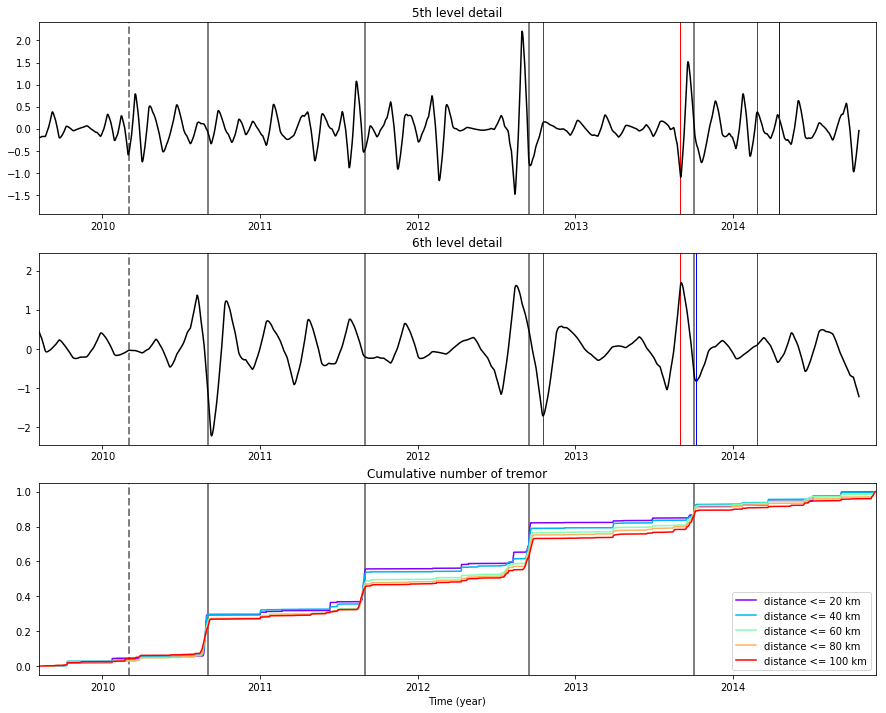

In [25]:
plt.figure(1, figsize=(15, 12))

# Plot 5th detail of DWT analysis
plt.subplot(311)
for i in range(0, len(time_ETS)):
    plt.axvline(time_ETS[i], linewidth=2, color='grey')
plt.axvline(2010.1667, linewidth=2, linestyle='--', color='grey')
for i in range(0, len(gap)):
    plt.axvline(time[gap[i]], linewidth=1, color='red')
plt.plot(time, D[4], 'k', label='Data')
plt.axvline(time[indb[4]], linewidth=1, color='blue')
plt.axvline(time[inde[4]], linewidth=1, color='blue')
plt.xlim(np.min(time_tremor), np.max(time_tremor))
plt.title('5th level detail')

# Plot 6th detail of DWT analysis
plt.subplot(312)
for i in range(0, len(time_ETS)):
    plt.axvline(time_ETS[i], linewidth=2, color='grey')
plt.axvline(2010.1667, linewidth=2, linestyle='--', color='grey')
for i in range(0, len(gap)):
    plt.axvline(time[gap[i]], linewidth=1, color='red')
plt.plot(time, D[5], 'k', label='Data')
plt.axvline(time[indb[5]], linewidth=1, color='blue')
plt.axvline(time[inde[5]], linewidth=1, color='blue')
plt.xlim(np.min(time_tremor), np.max(time_tremor))
plt.title('6th level detail')

# Compute the tremor tme for different distances from the GPS station
a = 6378.136
e = 0.006694470
lat0 = 48.65
lon0 = -123.45
dx = (pi / 180.0) * a * cos(lat0 * pi / 180.0) / sqrt(1.0 - e * e * sin(lat0 * pi / 180.0) * sin(lat0 * pi / 180.0))
dy = (3.6 * pi / 648.0) * a * (1.0 - e * e) / ((1.0 - e * e * sin(lat0 * pi / 180.0) * sin(lat0 * pi / 180.0)) ** 1.5)
dist = np.sqrt(np.power((lat_tremor - lat0) * dy, 2.0) + np.power((lon_tremor - lon0) * dx, 2.0))
dists = [20.0, 40.0, 60.0, 80.0, 100.0]
times = []
for i in range(0, len(dists)):
    k = dist <= dists[i]
    times.append(time_tremor[k])

# Plot cumulative number of tremor
plt.subplot(313)
for i in range(0, len(time_ETS)):
    plt.axvline(time_ETS[i], linewidth=2, color='grey')
plt.axvline(2010.1667, linewidth=2, linestyle='--', color='grey')
colors = cm.rainbow(np.linspace(0, 1, len(dists)))
for time_dist, distance, c in zip(times, dists, colors):
    nt = np.shape(time_dist)[0]
    plt.plot(np.sort(time_dist), (1.0 / nt) * np.arange(0, len(time_dist)), color=c, \
        label='distance <= {:2.0f} km'.format(distance))
plt.xlim(np.min(time_tremor), np.max(time_tremor))
plt.xlabel('Time (year)')
plt.title('Cumulative number of tremor')
plt.legend(loc=4)

plt.show()

We can see a small peak in the 5th level detail at a time that corresponds to a small increase of the cumulative number of tremor in March 2010. However, we cannot see evidence of small slow slip events outside of the big ETS events.

## References

W. Szeliga, T.I. Melbourne, M.M. Miller, and V.M. Santillan. Southern Cascadia episodic slow earthquakes. Geophysical Research Letters, 31:L16602, 2004.